In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy import stats
import json

In [13]:
def filter_data_new(data_in, max_step):
    """
    Only keeps data for tracks that are long enough for hurst exponent estimation at a given downsampling step size.
    Args: 
        data_in: pandas dataframe, original data
        max_step_size: int, maximum downsampling step size
        window: int, size of rolling window for hurst component estimation
    Returns:
        filtered_data: pandas dataframe
    """

    tracks_to_keep = data_in.TrackID.value_counts().loc[lambda x: x//max_step >2].reset_index()['index']

    filtered_data = data_in[data_in['TrackID'].isin(tracks_to_keep)]
    return filtered_data

def downsample(data_input, down_int, start_index=0):
    
    data_out = data_input.iloc[start_index::down_int]
   # print(data_out)
    return data_out



In [14]:
def get_mod(v):
    
    return np.sqrt(v.dot(v))

def get_step_vector(index,data_x,data_y,data_z):
    
    dx = data_x[index]-data_x[index-1]
    dy = data_y[index]-data_y[index-1]
    dz = data_z[index]-data_z[index-1]
    
    step_vector = np.array([dx,dy,dz])   

    return step_vector  

def get_ct(x_data,y_data,z_data):
    """
    iterates over a track (may be downsampled) and creates 1d array of cos(theta) values
    between each step
    """
    length=len(x_data)
    step_vectors = np.empty((length-1,3))
    cos_theta_temp = np.empty(length-2)
    for i in np.arange(length):
        if i>=1:
            step_vectors[i-1] = get_step_vector(i,x_data,y_data,z_data)
        if i>=2:
            v0 = step_vectors[i-2]
            v1 = step_vectors[i-1]
            cos_theta_temp[i-2] = np.dot(v0,v1)/(get_mod(v1)*get_mod(v0))
    return cos_theta_temp
    
def get_ct_ds_runs(track_data, ds_rate):
    """
    For a given track, applies downsampling and collects cos(theta) data for each 
    downsampling run (i.e. each of the 5 new tracks when downsampling an original track
    by 5) and appends the average of the cos theta track data to a 1d array
    """
    
    cos_theta_avgs_ds = np.array([])
    
    for i in np.arange(ds_rate):
        
        ds_track_data = downsample(track_data, ds_rate, start_index=i)
        
        x = ds_track_data['Position X'].values
        y = ds_track_data['Position Y'].values
        z = ds_track_data['Position Z'].values

        cos_theta_track = get_ct(x,y,z)
        
        #change to cos_theta_track, no averaging, to get batch2, resembling beta function
        avg_cos_theta_track = np.mean(cos_theta_track)
        
        cos_theta_avgs_ds = np.append(cos_theta_avgs_ds,avg_cos_theta_track)
    
    #change to np.mean(cos_theta_avgs_ds) for batch3 ( averaging across different downsamples)
    return cos_theta_avgs_ds
    
def get_ct_tracks(data_in,ds_rate,n_tracks=10000):
    
    cos_theta_tracks = np.array([])
    
    track_id_values = np.unique(data_in['TrackID'])
    
    for tid in track_id_values[:n_tracks]:

        track_data = data_in[data_in['TrackID']==tid]
        
        cos_theta_avg_ds = get_ct_ds_runs(track_data,ds_rate)
        
        cos_theta_tracks = np.append(cos_theta_tracks,cos_theta_avg_ds)
        
    return cos_theta_tracks
      
def get_cos_theta_dict(filtered_data, step_sizes,n_tracks=10000):
    """
    """
    cos_theta_dict = {}
    
    for i, s in enumerate(step_sizes):
        print('step_size ={}'.format(s))
        cos_theta_step = get_ct_tracks(filtered_data, s,n_tracks)
        cos_theta_dict["{}".format(s)] = cos_theta_step.tolist()
        
    return cos_theta_dict

def save_cos_theta_data(cos_theta_data, file_name,step_sizes,batch_number):#, window, step_sizes, restriction):
    """
    """
    with open('sim_pipe_cos_theta_data/sim_cos_theta_dict_'+file_name+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), 'w') as file:
        file.write(json.dumps(cos_theta_data))
      

In [16]:
filenames = np.array(['Control_frame001-200',
                      'Control_frame200-400',
                      'Control_frame400-600',
                      'Control_frame600-800',
                      'Control_frame800-1000',
                      'Control_frame1000-1200',
                      'LanB1_frame001-200',
                      'LanB1_frame200-400',
                      'LanB1_frame400-600',
                      'LanB1_frame600-800',
                      'LanB1_frame800-1000',
                      'LanB1_frame1000-1200',
                      'defLanB1_300817_frame200-400',
                      'defLanB1_300817_frame400-600'])

filenames_sim_stoch_hna00 = np.array(['stoch_h_hna0.0_r0.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r1.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r1.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r2.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r2.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r3.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r3.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r4.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r4.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r5.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r5.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r6.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r6.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r7.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r7.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r8.5_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r9.0_l200_mc250_cylinder_data',
                              'stoch_h_hna0.0_r9.5_l200_mc250_cylinder_data'])

filenames_sim_stoch_hna05 = np.array(['stoch_h_hna0.50_r0.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r1.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r1.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r2.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r2.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r3.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r3.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r4.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r4.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r5.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r5.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r6.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r6.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r7.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r7.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r8.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r8.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r9.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r9.50_l200_mc250_cylinder_data'])


In [17]:
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
n_tracks_restricted = 250

# iterate over data files and save H dictionary 
for i, file in enumerate(filenames_sim_stoch_hna00):
    print('opened file {}'.format(file))
    data = pd.read_csv('sim_haemocyte_pipe_data/' + file + '.csv')
    filtered_data = filter_data_new(data,max(step_sizes))
    cos_theta_dict = get_cos_theta_dict(filtered_data, step_sizes,n_tracks_restricted)
    #print(cos_theta_dict)
    save_cos_theta_data(cos_theta_dict, file,step_sizes,1)

opened file stoch_h_hna0.0_r0.5_l200_mc250_cylinder_data
step_size =1
step_size =2
step_size =3
step_size =4
step_size =5
step_size =6
step_size =7
step_size =8
step_size =9
step_size =10
step_size =11
step_size =12
step_size =13
step_size =14
step_size =15
opened file stoch_h_hna0.0_r1.0_l200_mc250_cylinder_data
step_size =1
step_size =2
step_size =3
step_size =4
step_size =5
step_size =6
step_size =7
step_size =8
step_size =9
step_size =10
step_size =11
step_size =12
step_size =13
step_size =14
step_size =15
opened file stoch_h_hna0.0_r1.5_l200_mc250_cylinder_data
step_size =1
step_size =2
step_size =3
step_size =4
step_size =5
step_size =6
step_size =7
step_size =8
step_size =9
step_size =10
step_size =11
step_size =12
step_size =13
step_size =14
step_size =15
opened file stoch_h_hna0.0_r2.0_l200_mc250_cylinder_data
step_size =1
step_size =2
step_size =3
step_size =4
step_size =5
step_size =6
step_size =7
step_size =8
step_size =9
step_size =10
step_size =11
step_size =12
step_size 

### Checking code against random walk and directed walk

In [5]:
import gen_walks as gw

##### Check for directed walk being 1

In [6]:
dwalk_pos = gw.gen_directed_walk(100)
cos_theta_directed = get_ct(dwalk_pos[:,0],dwalk_pos[:,1],dwalk_pos[:,2])
print(cos_theta_directed)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


##### Check for random walk being 0

In [7]:
samples = 10000
cos_theta_rwalk_data = np.empty(samples)
for i in np.arange(samples):
    
    rwalk = gw.random_walk_3d(1,100)
    cos_theta_rwalk_data[i] = np.mean(get_ct(rwalk[:,0],rwalk[:,1],rwalk[:,2]))
    
print(np.mean(cos_theta_rwalk_data))

-0.0009662512275829748


In [56]:
def get_ct_rwalk_pipe_data(mfp,samples, radius):
     
    ct_rwalk_pipe = np.empty(samples)
    
    for i in np.arange(samples):
    
        rwalk = gw.rwalk_3d_pipe(mfp,100,radius)
        ct_rwalk_pipe[i] = np.mean(get_ct(rwalk[:,0],rwalk[:,1],rwalk[:,2]))
        
    return np.mean(ct_rwalk_pipe),np.std(ct_rwalk_pipe)   

def get_ctrw_vs_r_data(mfp,samples_per_radius, radii):
    
    ct_r_data = np.empty((len(radii),2))
    
    for i,r in enumerate(radii):
        
        ct_r_data[i] = get_ct_rwalk_pipe_data(mfp,samples_per_radius,r)
        
    return ct_r_data
                

In [57]:
get_ct_rwalk_pipe_data(0.01,100,1)

(0.003959850443450725, 0.060984973614613455)

In [62]:
radii = np.linspace(1,10,20)
print(radii)

[ 1.          1.47368421  1.94736842  2.42105263  2.89473684  3.36842105
  3.84210526  4.31578947  4.78947368  5.26315789  5.73684211  6.21052632
  6.68421053  7.15789474  7.63157895  8.10526316  8.57894737  9.05263158
  9.52631579 10.        ]


In [63]:
ct_vs_r_data = get_ctrw_vs_r_data(3,100,radii)

<ErrorbarContainer object of 3 artists>

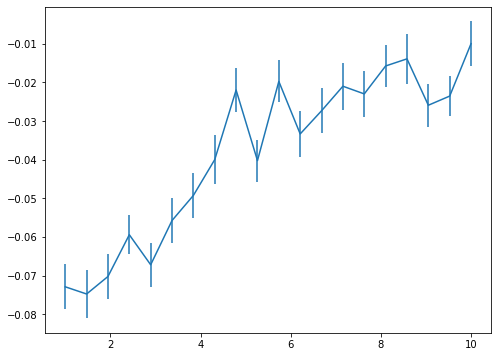

In [64]:
fig,ax = plt.subplots(figsize=(8,6))
plt.errorbar(x=radii,y=ct_vs_r_data[:,0],yerr=ct_vs_r_data[:,1]/np.sqrt(100))

## SCRAP

In [6]:

    #if restriction<len(tracks_to_keep):
     #   filtered_data = data_in[data_in['TrackID'].isin(tracks_to_keep[:restriction])]
    #else:
     #   filtered_data = data_in[data_in['TrackID'].isin(tracks_to_keep)]

def get_cos_theta(data_in,restriction):
    
    track_id_values = np.unique(data_in['TrackID'])
    cos_theta_avg = np.array([])
    
    print('------------')
    
    for tid in track_id_values[:restriction]:
        track_data = data_in[data_in['TrackID']==tid]
        x = track_data['Position X'].values
        y = track_data['Position Y'].values
        z = track_data['Position Z'].values
        
        cos_theta_temp = get_ct(x,y,z)

        cos_theta_avg = np.append(cos_theta_avg,np.mean(cos_theta_temp))
        
    return cos_theta_avg

def dsample_get_cos_theta(data_in, ds_rate,restriction):
    """
    Args:
        data_in: pandas dataframe
        ds_rate: int, downsampling step size
    Returns:
        h_arr: 2D np array
    """
    #cos_theta_avgs = np.array([])
    for i in np.arange(ds_rate):
        
        downsampled_data = downsample(data_in, ds_rate, start_index=i)

        cos_theta_avgs_temp = get_cos_theta(downsampled_data,restriction)
        print(len(cos_theta_avgs_temp))
            
        if i == 0:
            cos_theta_avgs = cos_theta_avgs_temp
        else:
            
            if len(cos_theta_avgs_temp)>len(cos_theta_avgs):
                cos_theta_avgs_temp=cos_theta_avgs_temp[:-1]
            
            cos_theta_avgs = np.append(cos_theta_avgs,cos_theta_avgs_temp)
        
    return cos_theta_avgs
